In [1]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,LSTM,Embedding,Dropout,Activation,GRU,Flatten
from keras.models import Model,Sequential
from keras.layers import Convolution1D
from keras import initializers,regularizers,constraints,optimizers,layers

Using TensorFlow backend.


In [2]:
#loading data
df = pd.read_csv('Reviews.csv')
df.shape

(568454, 10)

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#removing all the records with score = 3
df = df[df['Score']!=3]
df.shape

(525814, 10)

In [7]:
df['Score'] = df['Score'].apply(lambda x : 1 if x>3 else 0)

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
#checking for duplicated records
sorted_df = df.sort_values('ProductId',kind = 'quicksort',na_position = 'last')
df = sorted_df.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"},keep = 'first',inplace = False)
df.shape

(364173, 10)

In [7]:
df = df[df['HelpfulnessNumerator']<=df["HelpfulnessDenominator"]]
df.shape

(364171, 10)

In [8]:
#checking for class imbalance
df['Score'].value_counts()

5    250965
4     56096
1     36307
2     20803
Name: Score, dtype: int64

Text(0.5, 1.0, 'Bar plot of sentiments')

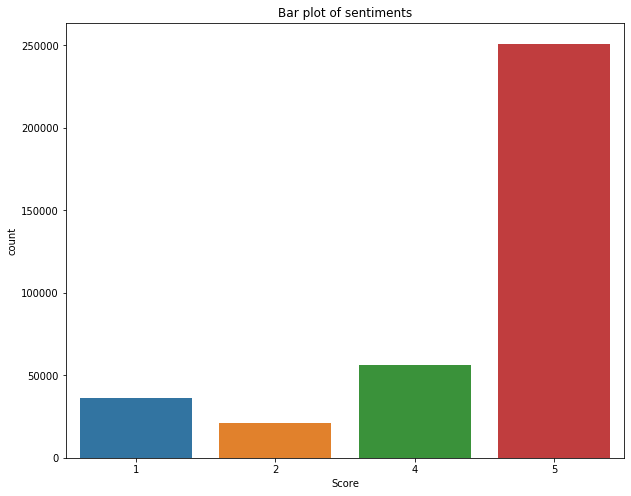

In [9]:
plt.figure(figsize = (10,8))
sns.countplot(df['Score'])
plt.title("Bar plot of sentiments")

In [10]:
#Text preprocessing
def decontract(text):
    text = re.sub(r"won\'t","will not",text)
    text = re.sub(r"can\'t","can not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [11]:
#custom stop words
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
lemmatizer = WordNetLemmatizer()

In [18]:
def preprocess_text(review):
    review = re.sub(r"http\S+","",review)                                      #removing website links
    review = BeautifulSoup(review,'lxml').get_text()                           #removing HTML tags
    review = decontract(review)                                                #decontracting
    review = re.sub("\S*\d\S*","",review).strip()                              #removing words with numeric digits
    review = re.sub('[^A-Za-z]+',' ',review)                                   #removing non word characters
    review = review.lower()                                                    #lower case
    review = [word for word in review.split(" ") if not word in stop_words]    #removing stop words
    review = [lemmatizer.lemmatize(token,"v") for token in review]             #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
df['Text'] = df['Text'].apply(lambda x : preprocess_text(x))

In [19]:
df['Text'].head()

150523    witty little book make son laugh loud recite c...
150505    grow read sendak book watch really rosie movie...
150506    fun way children learn months year learn poems...
150507    great little book read aloud nice rhythm well ...
150508    book poetry months year go month cute little p...
Name: Text, dtype: object

In [23]:
#splitting the model in test and training set
train_df,test_df = train_test_split(df,test_size = 0.2,random_state = 42)
print("training data size : " ,train_df.shape)
print("test data size : " , test_df.shape)

training data size :  (291336, 10)
test data size :  (72835, 10)


In [24]:
#Model
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])

max_review_length = 130
X_train = pad_sequences(list_tokenized_train ,maxlen = max_review_length)
y_train = train_df['Score']

In [25]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words+1,embedding_vector_length,input_length = max_review_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 245,333
Trainable params: 245,333
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train,y_train,nb_epoch = 3,batch_size = 64,validation_split = 0.2)

C:\Users\amayd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.
C:\Users\amayd\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 233068 samples, validate on 58268 samples
Epoch 1/3
233068/233068 [==============================] - 545s 2ms/step - loss: -630.6570 - accuracy: 0.1001 - val_loss: -1224.4362 - val_accuracy: 0.0994
Epoch 2/3
233068/233068 [==============================] - 517s 2ms/step - loss: -1813.5786 - accuracy: 0.1001 - val_loss: -2411.4830 - val_accuracy: 0.0994
Epoch 3/3
233068/233068 [==============================] - 504s 2ms/step - loss: -3004.6356 - accuracy: 0.1001 - val_loss: -3604.8613 - val_accuracy: 0.0994


In [29]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['Text'])
X_test = pad_sequences(list_tokenized_test,maxlen = max_review_length)
y_test = test_df['Score']
prediction = model.predict(X_test)
y_pred = (prediction >0.5)
print("Accuracy of the model :",accuracy_score(y_test,y_pred))
print("F1-score :",f1_score(y_test,y_pred))
print("confusion matrix :")
confusion_matrix(y_test,y_pred)

Accuracy of the model : 0.09877119516715864


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].